In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ase.io import read
from ase.visualize import view
import numpy as np 
import torch 
import metatensor 
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)

In [3]:
from metatensor import Labels, TensorBlock, TensorMap
from mlelec.data.dataset import PySCFPeriodicDataset
from mlelec.utils.twocenter_utils import fix_orbital_order

/home/nigam/miniconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [4]:
orbitals = {'sto-3g': {6: [[1,0,0],[2,0,0],[2,1,1], [2,1,-1],[2,1,0]]}, 
            'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]}}

In [6]:
root = 'examples/data/periodic/graphene_supercell_variety'
ORBS = 'sto-3g'
graphene = read(f'{root}/graphene_variety.xyz', '1')
graphene.pbc = True

kmesh = [8,8,1]
kfock = np.load(f"{root}/fock_hex_881.npy")
kover = np.load(f"{root}/over_hex_881.npy")

for ik, k in enumerate(kfock):
    kfock[ik] = fix_orbital_order(k, graphene, orbitals[ORBS]) #### TODO <<

dataset = PySCFPeriodicDataset(frames = [graphene], kmesh = kmesh, fock_kspace = [kfock], overlap_kspace = [kover], device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS)

# Targets

In [37]:
from metatensor import load 
from mlelec.utils.twocenter_utils import _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks 

def get_targets(dataset, device ="cpu", cutoff = None, target='fock'):
    if target.lower() == 'fock':
        matrices_negative = dataset._fock_realspace_negative_translations
    elif target.lower() == 'overlap':
        matrices_negative = dataset._overlap_realspace_negative_translations
    else: 
        raise ValueError('target must be fock or overlap')
    blocks = matrix_to_blocks(dataset, matrices_negative , device = 'cpu', cutoff = cutoff, all_pairs = True, target= target)
    coupled_blocks = _to_coupled_basis(blocks, skip_symmetry = True, device = device, translations = True)

    blocks = blocks.keys_to_samples('cell_shift_a')
    blocks = blocks.keys_to_samples('cell_shift_b')
    blocks = blocks.keys_to_samples('cell_shift_c')

    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_a')
    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_b')
    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_c')
    return blocks , coupled_blocks

In [8]:
cutoff = 6
# target_blocks_c, target_coupled_blocks_c = get_targets(dataset, cutoff = cutoff)
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff)


# Features

In [9]:
from mlelec.features.acdc import pair_features, single_center_features, twocenter_features_periodic_NH

hypers_pair = {'cutoff': cutoff,
               'max_radial': 10,
               'max_angular': 4,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

hypers_atom = {'cutoff': 4,
               'max_radial': 10,
               'max_angular': 4,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

return_rho0ij = False
both_centers = True
all_pairs = False
LCUT = 3

rhoij = pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = all_pairs, both_centers = both_centers, mic = True,
                      kmesh = dataset.kmesh, device="cpu", lcut = LCUT, return_rho0ij = return_rho0ij, counter = dataset._translation_counter, 
                      T_dict = dataset._translation_dict)

if both_centers and not return_rho0ij:
    NU = 3
else:
    NU = 2
rhonui = single_center_features(dataset.structures, hypers_atom, order_nu = NU, lcut = LCUT, device = 'cpu',
                                feature_names = rhoij.property_names)

hfeat = twocenter_features_periodic_NH(single_center = rhonui, pair = rhoij, all_pairs = True)

{'cutoff': 6, 'max_radial': 10, 'max_angular': 4, 'atomic_gaussian_width': 0.3, 'center_atom_weight': 1, 'radial_basis': {'Gto': {}}, 'cutoff_function': {'ShiftedCosine': {'width': 0.1}}}


/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:148: UserWarning: Using kmesh [[8, 8, 1]] for MIC mapping
  warnings.warn(f"Using kmesh {kmesh} for MIC mapping")
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:267: UserWarning: nu_j not defined, using nu_i for nu_j as well
  warnings.warn("nu_j not defined, using nu_i for nu_j as well")


In [10]:
# target_samples = target_coupled_blocks[20].samples
# blocks = []
# for k, b in hfeat.items():
#     if k['block_type']==0:
#         blocks.append(b.copy())
#     else: 
#         flbls = Labels(hfeat.sample_names[:6], np.array(b.samples.values[:,:6]))
#         idx = np.where(flbls.intersection_and_mapping(target_samples)[1] != -1)[0]
#         samples = Labels(hfeat.sample_names, np.array(b.samples.values[idx].tolist()))
#         blocks.append(TensorBlock(components = b.components, 
#                                   properties = b.properties,
#                                   samples = samples, 
#                                   values = b.values[idx]))

# hfeat_cutoff = TensorMap(hfeat.keys, blocks)

# Train

In [255]:
from mlelec.models.linear import LinearModelPeriodic
device='cpu'

In [256]:
def train_ridge(model, target_blocks, set_bias=False):
    block_losses = {}
    loss = 0
    pred, ridges, kernels = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

In [257]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks,
                                                                         set_bias = True)
print(loss_ridge_bias)

tensor(7.0218e-14)


(1e-12, 10000.0)

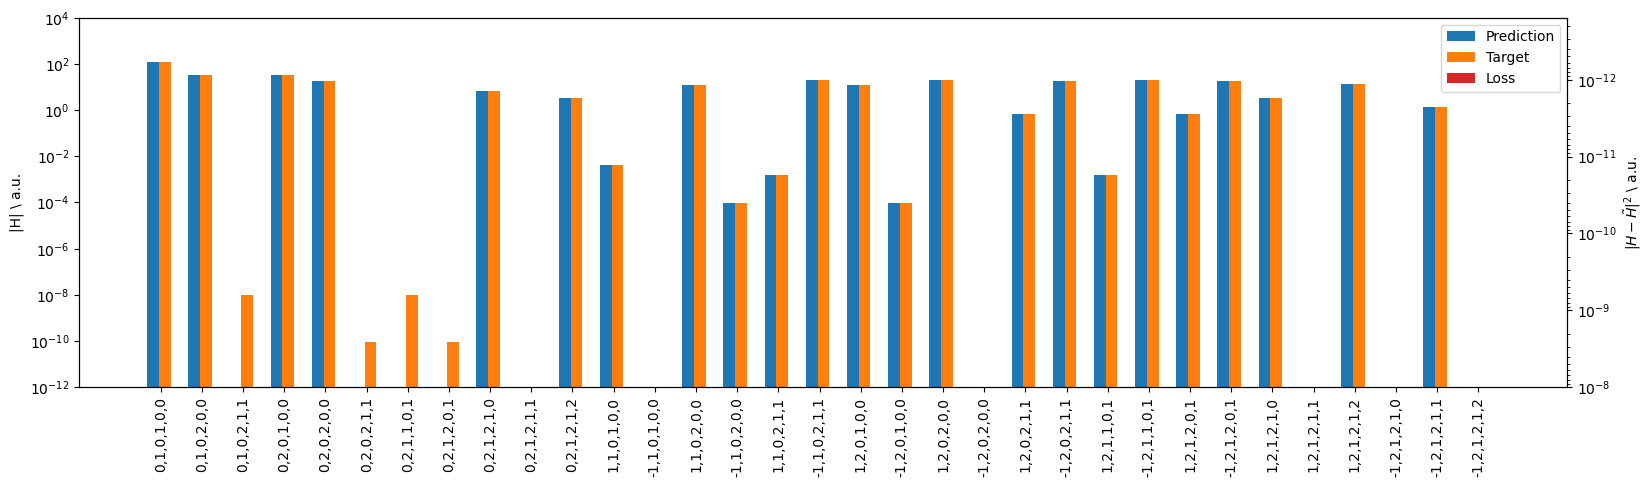

In [258]:
from mlelec.utils.plot_utils import plot_block_errors
fig,ax,ax_loss=plot_block_errors(target_coupled_blocks, pred_ridge_bias, plot_loss = True)
ax_loss.set_ylim(1e-8,)
ax.set_ylim(1e-12,1e4)

## C2 174

In [74]:
workdir = '/home/nigam/scratch/MAC/k-hamiltonian/'
root = f'{workdir}/examples/data/periodic/c2/'
ORBS = 'sto-3g'
START = 100
STOP = 150
frames = read(f'{root}/C2_174.extxyz', slice(START, STOP))
for f in frames: 
    f.pbc = True

kmesh = [8,8,1]
kfock = [np.load(f"{root}/results_C2_174_881/fock_{i}_881.npy") for i in range(START, STOP)]
kover = [np.load(f"{root}/results_C2_174_881/over_{i}_881.npy") for i in range(START, STOP)]
for ifr in range(len(frames)):
    for ik, k in enumerate(kfock[ifr]):
        kfock[ifr][ik] = fix_orbital_order(k, frames[ifr], orbitals[ORBS]) #### TODO <<
        kover[ifr][ik] = fix_orbital_order(kover[ifr][ik], frames[ifr], orbitals[ORBS]) #### TODO <<

dataset = PySCFPeriodicDataset(frames = frames, kmesh = kmesh, fock_kspace = kfock, overlap_kspace = kover, device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS)

In [75]:
cutoff = 6
target_blocks_nc, target_coupled_blocks_nc = get_targets(dataset, cutoff = None)
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff)

target_blocks_nc_over, target_coupled_blocks_nc_over = get_targets(dataset, cutoff = None, target='overlap')
target_blocks_over, target_coupled_blocks_over = get_targets(dataset, cutoff = cutoff, target='overlap')


In [76]:
from mlelec.utils.pbc_utils import blocks_to_matrix
reconstructed_H = blocks_to_matrix(target_blocks, dataset)
reconstructed_S = blocks_to_matrix(target_blocks_over, dataset)

reconstructed_H_nc = blocks_to_matrix(target_blocks_nc, dataset)
reconstructed_S_nc = blocks_to_matrix(target_blocks_nc_over, dataset)


In [53]:
# for ifr in range(START, STOP): 
#     for T,rH in reconstructed_H_nc[ifr].items():
#         norm = torch.norm(rH - dataset.fock_realspace[ifr][T])
#         if norm>1e-10:
#             print(f'frame {ifr} T {T} norm {norm}')
#         rS = reconstructed_S_nc[ifr][T]
#         norm = torch.norm(rS - dataset.overlap_realspace[ifr][T])
#         if norm>1e-10:
#             print(f'frame {ifr} T {T} norm {norm}')


/tmp/ipykernel_170685/3525895685.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')
/tmp/ipykernel_170685/3525895685.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


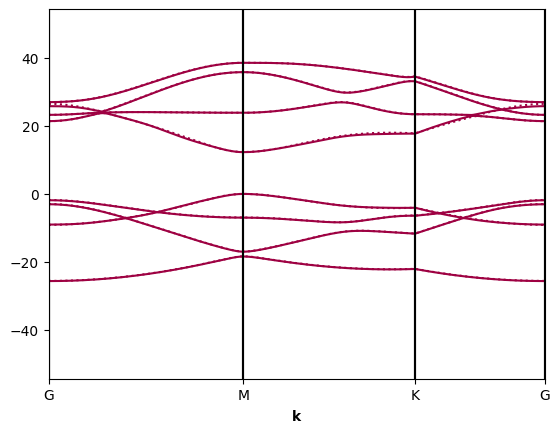

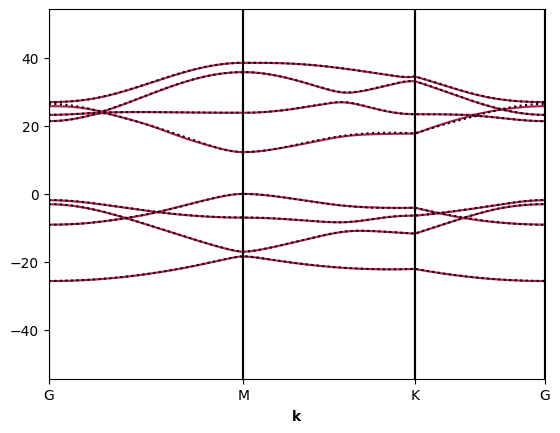

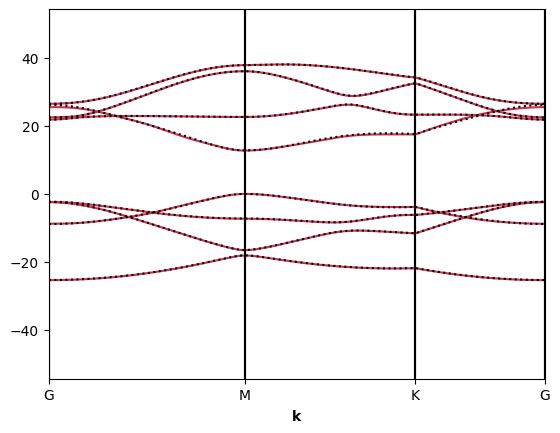

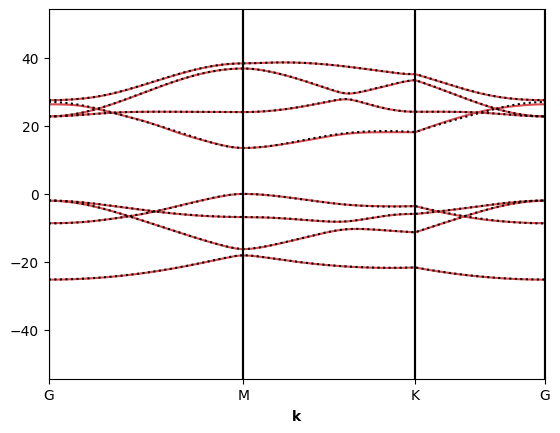

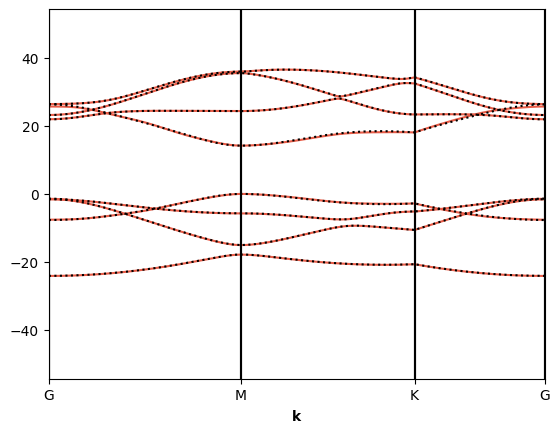

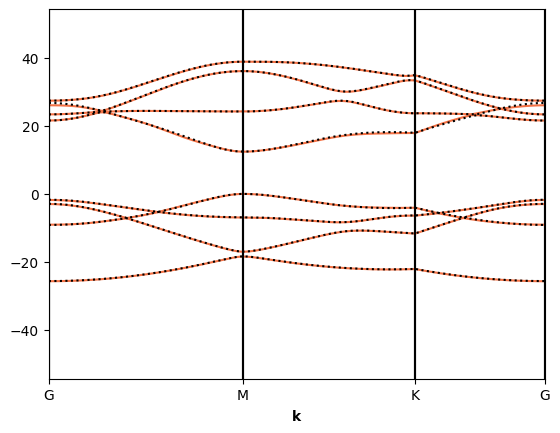

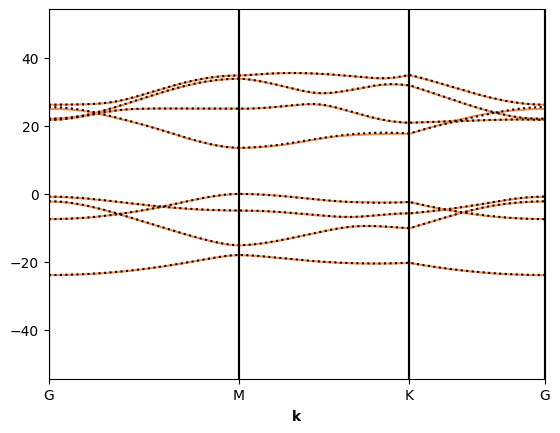

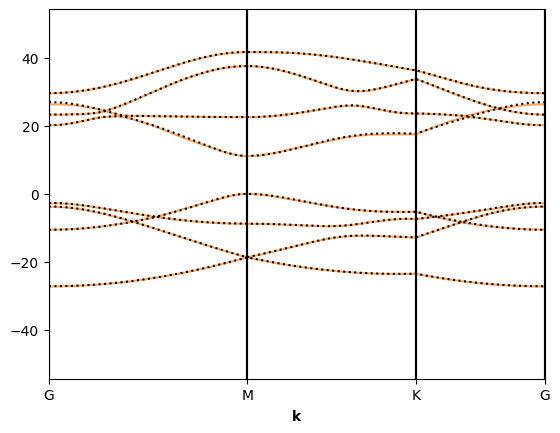

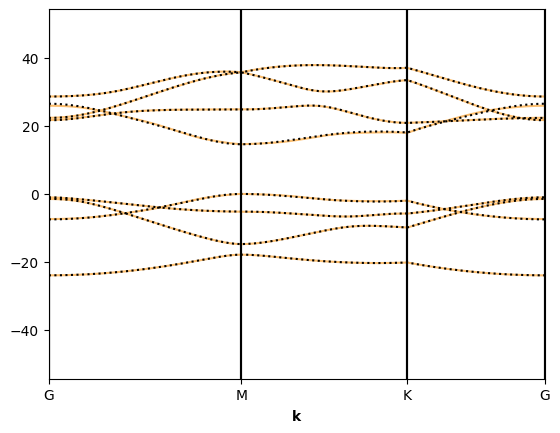

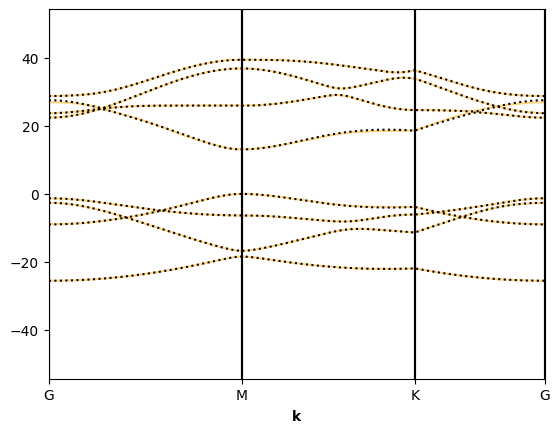

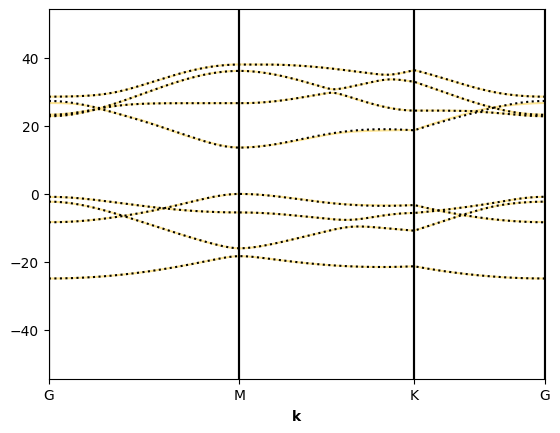

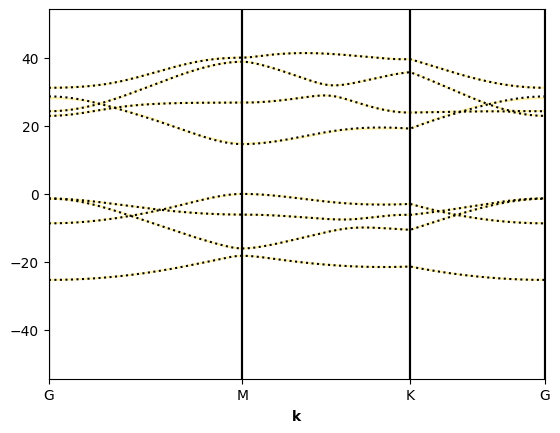

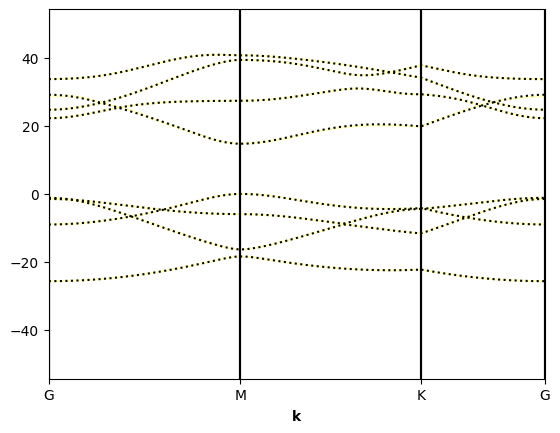

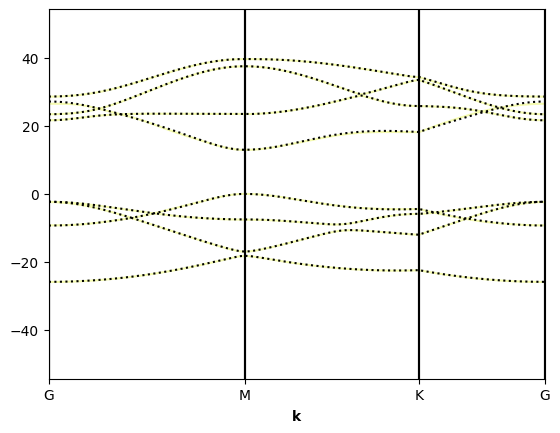

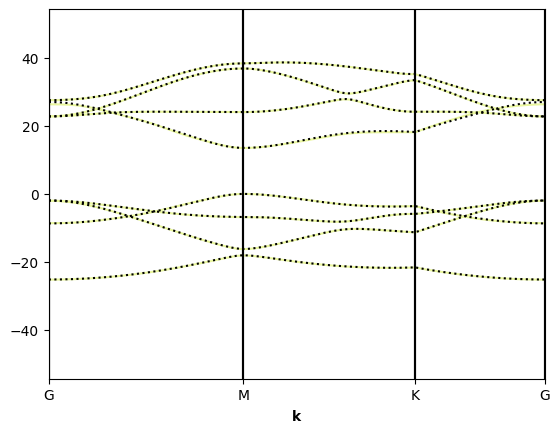

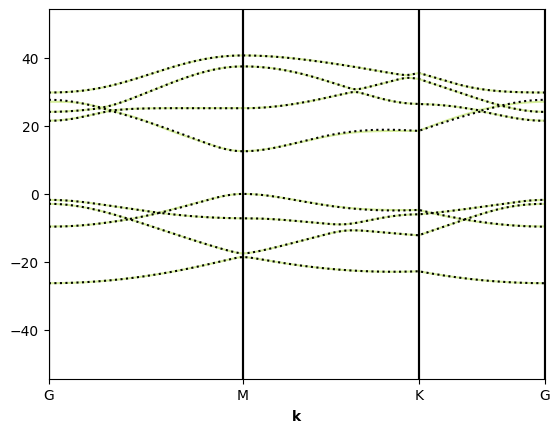

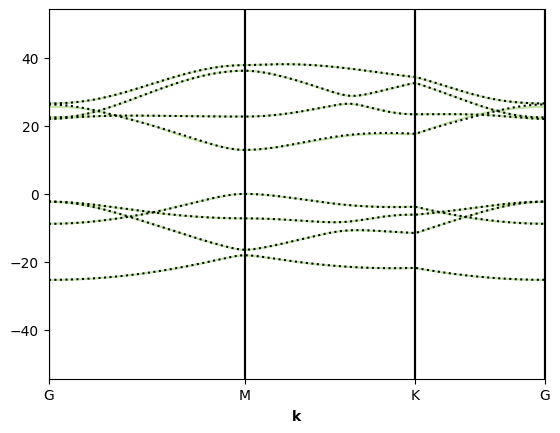

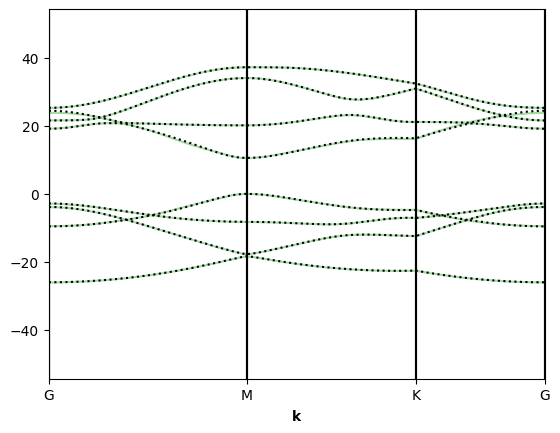

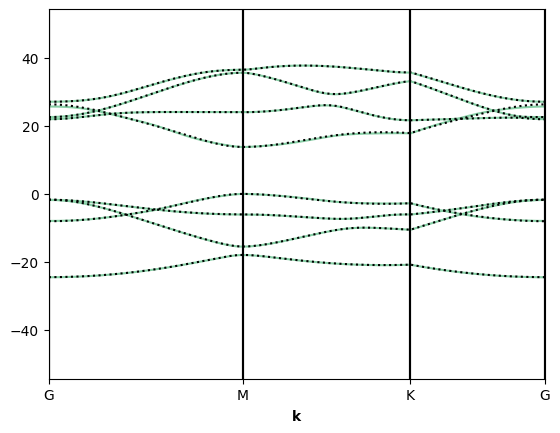

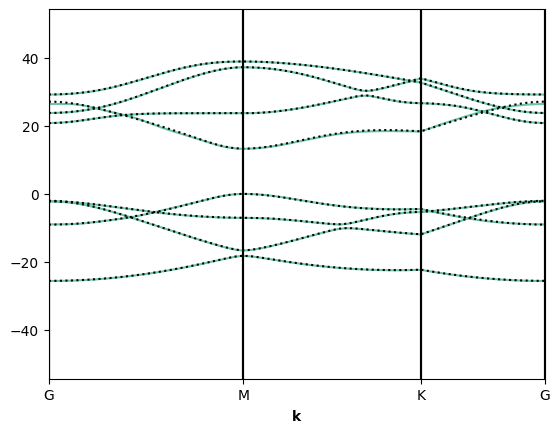

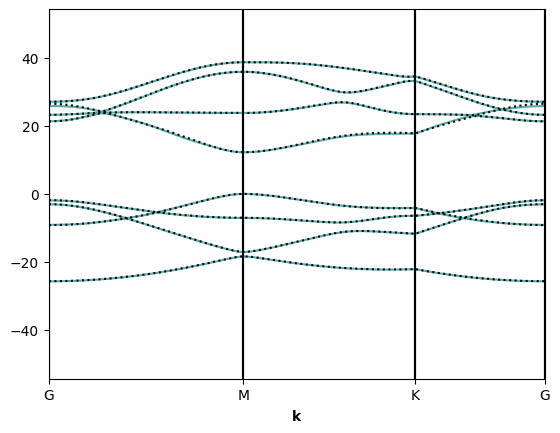

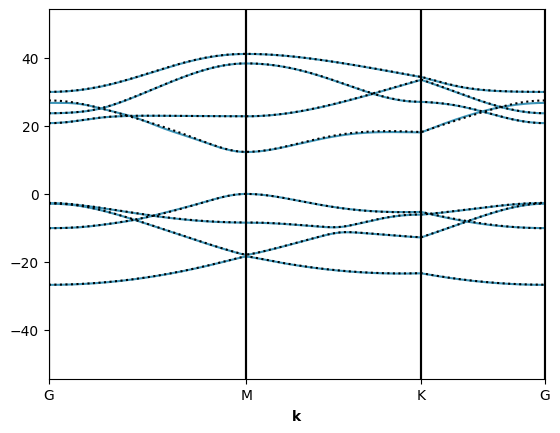

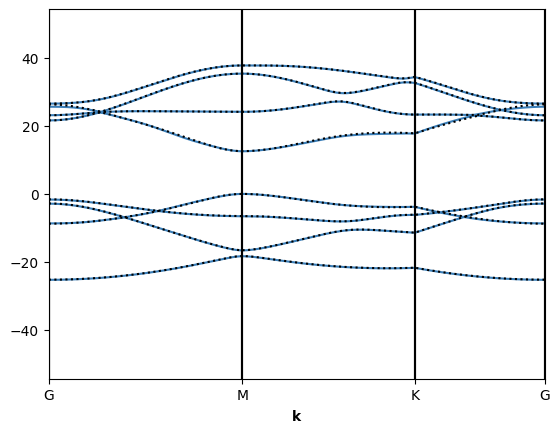

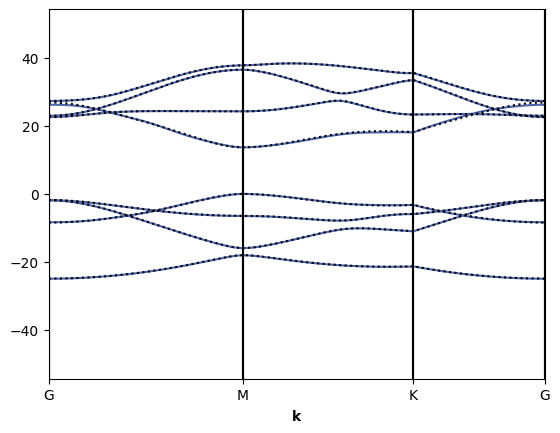

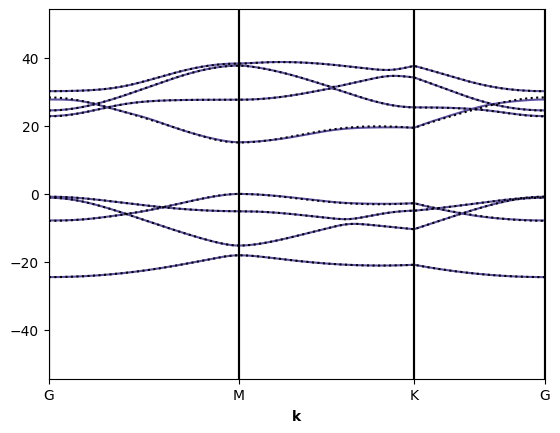

In [79]:
fig, ax = plt.subplots()

special_points = {'G': [0.0, 0.0, 0.0], 'K': [0.3333333333333333, -0.3333333333333333, 0.0], 'M': [0.5, 0.0, 0.0]}

from mlelec.utils.plot_utils import plot_bands_frame_
import matplotlib

cmap = matplotlib.cm.get_cmap('Spectral')


ifr = 0
frame = dataset.structures[ifr]
pyscf_cell = dataset.cells[ifr]
kmesh = dataset.kmesh[ifr]
kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
realfock = np.asarray(list(dataset.fock_realspace[0].values()))
realover = np.asarray(list(dataset.overlap_realspace[0].values()))

realfock_cutoff = np.asarray(list(reconstructed_H[0].values()))
realover_cutoff = np.asarray(list(reconstructed_S[0].values()))

ax, b = plot_bands_frame_(frame, realfock, realover, pyscf_cell, [8,8,1], special_symm = 'hexagonal', kpath = kpath, ax = ax, color = cmap(0))
ax, b = plot_bands_frame_(frame, realfock_cutoff, realover_cutoff, pyscf_cell, [8,8,1], special_symm = 'hexagonal', kpath = kpath, ax = ax, color = cmap(0), ls= ':')


nmax = 50
for ifr in range(0, nmax):
    frame = dataset.structures[ifr]
    pyscf_cell = dataset.cells[ifr]
    kmesh = dataset.kmesh[ifr]
    kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
    realfock = np.asarray(list(dataset.fock_realspace[ifr].values()))
    realover = np.asarray(list(dataset.overlap_realspace[ifr].values()))
    realfock_cutoff = np.asarray(list(reconstructed_H[ifr].values()))
    realover_cutoff = np.asarray(list(reconstructed_S[ifr].values()))
    fig, ax = plt.subplots()
    ax, b = plot_bands_frame_(frame, realfock, realover, pyscf_cell, kmesh = [8,8,1], special_symm = 'hexagonal' , 
                              kpath = kpath, ax=ax,color = cmap((ifr+1)/nmax))
    ax, b = plot_bands_frame_(frame, realfock_cutoff, realover_cutoff, pyscf_cell, kmesh = [8,8,1], special_symm = 'hexagonal' , 
                              kpath = kpath, ax = ax, color = 'k', ls = ':')



In [7]:
from ase.io import read
from ase.visualize import view
import numpy as np
import torch
import metatensor
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)
import hickle

from metatensor import Labels, TensorBlock, TensorMap
from mlelec.data.dataset import PySCFPeriodicDataset
from mlelec.utils.twocenter_utils import fix_orbital_order
from pathlib import Path
from mlelec.features.acdc import pair_features, single_center_features, twocenter_features_periodic_NH

def check_target(coupled_blocks, tol=1e-4):
    """ Checks that the coupled blocks, when n1, l1 = n2, l2, satisfy 
            - block_type=1, lambda = ODD blocks are zero, 
            - block_type=-1, lambda = EVEN blocks are zero 
    """
    for k, b in coupled_blocks.items():
        btype= k['block_type']
        L = k['L']
        l1 = k['l_i']
        l2 = k['l_j']
        n1 = k['n_i']
        n2 = k['n_j']
        if L%2==0 and btype==-1 and (n1==n2) and (l1==l2):
            try:
                 assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{k}, {torch.norm(b.values)} : {len(failidx)} failing samples - , {b.samples.values[failidx].tolist()}')#, values,{b.values[failidx]}' )

        elif L%2==1 and btype==1 and (n1==n2) and (l1==l2):
            try:
                assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{len(failidx)} failing samples, {b.samples.values[failidx]}')#, values,{b.values[failidx]}' )

                # print(f'try minus bytpe, {torch.norm(newb.values[failidx])}')

orbitals = {'sto-3g': {6: [[1,0,0],[2,0,0],[2,1,1], [2,1,-1],[2,1,0]]}, 
            'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]}}

from metatensor import load 
from mlelec.utils.twocenter_utils import _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks 

def get_targets(dataset, device ="cpu", cutoff = None, target='fock'):
    if target.lower() == 'fock':
        matrices_negative = dataset._fock_realspace_negative_translations
    elif target.lower() == 'overlap':
        matrices_negative = dataset._overlap_realspace_negative_translations
    else: 
        raise ValueError('target must be fock or overlap')
    blocks = matrix_to_blocks(dataset, matrices_negative , device = 'cpu', cutoff = cutoff, all_pairs = True, target= target)
    coupled_blocks = _to_coupled_basis(blocks, skip_symmetry = True, device = device, translations = True)

    blocks = blocks.keys_to_samples('cell_shift_a')
    blocks = blocks.keys_to_samples('cell_shift_b')
    blocks = blocks.keys_to_samples('cell_shift_c')

    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_a')
    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_b')
    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_c')
    return blocks , coupled_blocks



ORBS = 'sto-3g'
root = 'examples/data/periodic/c2/'
device='cpu'
workdir = "n12l4_all_new"
# Path(workdir).mkdir(exist_ok = True)
START = 0
STOP = 6
# Load graphene structure
frames = read(f'{root}/C2_174.extxyz', slice(START, STOP)) # will be automated from filename  
fock_range = list(range(START, STOP))
for frame in frames:
    frame.pbc = True
    # frame.wrap()

kmesh = [8,8,1]
kfock = np.array([np.load(f'{root}/fock_{i}_881.npy') for i in fock_range])
# kover = np.array([np.load(f'{root}/c2_174/over_{i}_881.npy') for i in fock_range])
print('kfock', kfock.shape, flush=True)

for ifr in range(len(frames)):
    for ik, k in enumerate(kfock[ifr]):
        kfock[ifr][ik] = fix_orbital_order(k, frames[ifr], orbitals[ORBS]) 
        # kover[ifr][ik] = fix_orbital_order(kover[ifr][ik], frames[ifr], orbitals[ORBS]) 

dataset = PySCFPeriodicDataset(frames = frames, kmesh = kmesh, fock_kspace = kfock, device = device, orbs = orbitals[ORBS])


cutoff = 6
# target_blocks_c, target_coupled_blocks_c = get_targets(dataset, cutoff = cutoff)
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff)

hypers_pair = {'cutoff': cutoff,
               'max_radial': 10,
               'max_angular': 4,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

hypers_atom = {'cutoff': 4,
               'max_radial': 10,
               'max_angular': 4,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

return_rho0ij = False
both_centers = False
all_pairs = False
LCUT = 3

rhoij = pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = all_pairs, both_centers = both_centers, mic = True,
                      kmesh = dataset.kmesh, device="cpu", lcut = LCUT, return_rho0ij = return_rho0ij, counter = dataset._translation_counter, 
                      T_dict = dataset._translation_dict)

if both_centers and not return_rho0ij:
    NU = 3
else:
    NU = 2
rhonui = single_center_features(dataset.structures, hypers_atom, order_nu = NU, lcut = LCUT, device = 'cpu',
                                feature_names = rhoij.property_names)

hfeat = twocenter_features_periodic_NH(single_center = rhonui, pair = rhoij, all_pairs = True)

kfock (6, 64, 10, 10)


/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/data/dataset.py:798: UserWarning: No real space or kspace overlap set
  warnings.warn('No real space or kspace overlap set')


{'cutoff': 6, 'max_radial': 10, 'max_angular': 4, 'atomic_gaussian_width': 0.3, 'center_atom_weight': 1, 'radial_basis': {'Gto': {}}, 'cutoff_function': {'ShiftedCosine': {'width': 0.1}}}


/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:148: UserWarning: Using kmesh [[8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1]] for MIC mapping
  warnings.warn(f"Using kmesh {kmesh} for MIC mapping")


In [8]:
from mlelec.models.linear import LinearModelPeriodic
from mlelec.utils.plot_utils import plot_block_errors
device='cpu'

def train_ridge(model, target_blocks, set_bias=False, kernel_ridge=False):
    block_losses = {}
    loss = 0
    pred, ridges = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias, kernel_ridge=kernel_ridge)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 


NTRAIN = 3
trainidx = list(range(START, NTRAIN))
testidx = list(range(NTRAIN, STOP) )

hfeat_test = mts_slice(hfeat, axis="samples", labels= Labels(["structure"], values = np.array(testidx).reshape(-1,1)))
target_coupled_blocks_test = mts_slice(target_coupled_blocks, axis="samples", labels= Labels(["structure"], values = np.array(testidx).reshape(-1,1)))


seed = 2244
np.random.seed(seed)
maxtrain_indices = trainidx.copy()
shuffle(maxtrain_indices)

trainfrac = n\p.array([10, 25, 50, 100,150])#/len(frames)
use_kernel_ridge = False
for tf in trainfrac[:-1]:
    train_idx = maxtrain_indices[:tf]
    train_labels = Labels(["structure"], values = np.array(train_idx).reshape(-1,1))
    hfeat_tf = mts_slice(hfeat, axis='samples', labels = train_labels )
    target_tf = mts_slice(target_coupled_blocks, axis='samples', labels = train_labels )
    model_ridge = LinearModelPeriodic(
                                  twocfeat = hfeat_tf,
                                  target_blocks = target_tf,
                                  frames = dataset.structures, orbitals= dataset.basis,
                                  cell_shifts = None, device = device)

    model_ridge = model_ridge.double()

    from datetime import datetime
    now = datetime.now().strftime("%H:%M:%S")
    print(f"Start training train frac{tf} at {now}", flush = True)
    loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, target_tf, set_bias=True, kernel_ridge = use_kernel_ridge)
    now = datetime.now().strftime("%H:%M:%S")
    print(f"Training finished at {now}", flush = True)

    print(f'Loss @ tf{tf} = {loss_ridge_bias}', flush = True)

    fig,ax,ax_loss=plot_block_errors(target_tf, pred_ridge_bias, plot_loss=True)
    ax_loss.set_ylim(1e-12,);
    fig.tight_layout()
    fig.savefig(f'{workdir}/plot_errors_tf{tf}.pdf', bbox_inches = 'tight')
    
    #pred_ridge_bias.save(f'{workdir}/pred_ridges_bias.npz')
    hickle.dump(ridges_bias, f'{workdir}/ridges_bias_tf{tf}.hkl', mode = 'w')
    
    now = datetime.now().strftime("%H:%M:%S")
    print(f"TRAINED tf {tf} at {now}. Predicting test set")
    
    #-------------------- TEST------------
    pred_blocks = []
    dummy_property = target_coupled_blocks[0].properties
    targetkeynames = target_coupled_blocks.keys.names
    
    for imdl, (key, tkey) in enumerate(zip(model_ridge.model, target_coupled_blocks_test.keys )):
        target = target_coupled_blocks_test.block(tkey)
        nsamples, ncomp, nprops = target.values.shape
    
        feat = map_targetkeys_to_featkeys(hfeat_test, tkey)
        x = ((feat.values.reshape((feat.values.shape[0] * feat.values.shape[1], -1))/1).cpu().numpy())
        pred = ridges_bias[imdl].predict(x) # kernel ridge automatically computes the kernel
        assert np.all(feat.samples.values[:,:6] == target.samples.values), (feat.samples.values[:,:6], target.samples.values)
        pred_blocks.append(
                        TensorBlock(
                            values = torch.from_numpy(pred.reshape((nsamples, ncomp, 1))).to(device),
                            samples = target.samples,
                            components = target.components,
                            properties = dummy_property,
                            )
                        )
    print('', flush = True)
    print('', flush = True)
    print('', flush = True)
    print('', flush = True)


    pred = TensorMap(target_coupled_blocks_test.keys, pred_blocks)
    loss = {}
    for (k, tb) in target_coupled_blocks_test.items():
        feat = map_targetkeys_to_featkeys(hfeat_test, k)
        loss[tuple(k)]= torch.norm(tb.values - pred.block(k).values)**2
        print(' '.join([f'{key:>2d}' for key in k.values]), f'f: {torch.linalg.norm(feat.values):>10.6f} | t: {torch.norm(tb.values):>10.6f} | loss: {torch.sum((tb. values - pred.block(k).values)**2):>10.6f}', flush = True )
         
    print('LOSS:', sum(loss.values()))
    fig,ax,ax_loss=plot_block_errors(target_coupled_blocks_test, pred, plot_loss=True)
    ax_loss.set_ylim(1e-12,);
    fig.tight_layout()
    fig.savefig(f'{workdir}/plot_errors_test_tf{tf}.pdf', bbox_inches = 'tight')
    pred.save(f'{workdir}/predictions_test_tf{tf}')
 

NameError: name 'mts_slice' is not defined